# I. Import libraries and load dataset 

In [1]:
import os
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import optuna

c:\Users\PC\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CFG:
    seed = 42
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    SMALL_GAP = 6 
    lookback = 24
    horizon = 2
    epochs = 6
    lr = 1e-3
    models_dir = './models'
    os.makedirs(models_dir, exist_ok=True)

torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
if CFG.device == 'cuda':
    torch.cuda.manual_seed_all(CFG.seed)

MASK_VALUE = 0.0 

Load dataset

In [ ]:
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets  

# II. Sanity check and EDA

In [ ]:
df = X.copy()
df['traffic_volume'] = y.copy()
df.head()

Check columns data types

In [ ]:
df.info()

Transform date_time to datetime format

In [ ]:
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.sort_values("date_time").reset_index(drop=True)

Drop duplicated rows 

In [ ]:
df.duplicates().sum()

In [ ]:
df.drop_duplicates(inplace=True)

Check featuers statistic and distribution

In [ ]:
df.describe()

In [ ]:
numerical_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten() 

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, ax=axes[i]) 
    axes[i].set_title(f'Box Plot of {col}', fontsize=14)
    axes[i].set_ylabel(col, fontsize=12)
        
if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Outlier Visualization using Box Plots', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 1.0])
plt.show()

Handle invalid data

temp

In [ ]:
df['temp'] = df['temp'].replace(0, np.nan)

rain_1h

In [ ]:
real_max_rain = df.loc[df['rain_1h'] < 100, 'rain_1h'].max()
df.loc[df['rain_1h'] > 100, 'rain_1h'] = real_max_rain

Handle mising value in holiday column

In [ ]:
df['holiday'] = df['holiday'].fillna('None')
df['is_holiday'] = (df['holiday'] != 'None').astype(int)
df = df.drop(columns=["holiday"])

## 3. Gộp timestamp bị trùng and handle missing time stamp

### Gộp duplicated timestamp

In [ ]:
original_df = df.copy()

numeric_cols = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]
cate_col = ['weather_description', 'weather_main']
first_cols = ["is_holiday"]

# Hàm lấy Mode an toàn (trả về giá trị đầu tiên nếu có nhiều mode)
def get_mode(x):
    m = pd.Series.mode(x)
    return m.iloc[0] if not m.empty else np.nan

df_grouped = df.groupby("date_time").agg(
    {**{c: "mean" for c in numeric_cols},
     **{c: get_mode for c in cate_col},
     **{c: "max" for c in first_cols}}
).reset_index()

### Reindex & interpolate missing short timestamp gap

In [ ]:
start = df['date_time'].min()
end = df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq="h") 

df_full = df_grouped.set_index('date_time').reindex(full_range)
df_full.index.name = 'date_time'

# Đánh dấu dữ liệu gốc có tồn tại hay không
original_exists = df.set_index('date_time').index
df_full['timestep_mask'] = df_full.index.isin(original_exists).astype(int)

cols_to_interp = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]

# 4.1 Mask cho khoảng trống nhỏ (Small Gaps)
# Logic: Chỉ những chỗ nội suy được trong phạm vi SMALL_GAP mới là data dùng được
mask_filled = np.ones(len(df_full), dtype=bool)

for col in cols_to_interp:
    mask_col = df_full[col].interpolate(
        method="time",
        limit=CFG.SMALL_GAP,
        limit_direction="forward"
    ).notna()

    mask_filled &= mask_col   # chỉ giữ lại timestep valid ở tất cả các cột

mask_filled = mask_filled.astype(int)

# 4.2 Thực hiện Interpolate
df_full[cols_to_interp] = df_full[cols_to_interp].interpolate(method='time', limit=CFG.SMALL_GAP, limit_direction='forward')
df_full[cate_col] = df_full[cate_col].ffill(limit=CFG.SMALL_GAP)

# 4.3 Update Mask & Clean Large Gaps
df_full['timestep_mask'] = mask_filled 
# Những chỗ Gap quá lớn (lớn hơn limit) sẽ vẫn còn NaN -> Fill bằng 0 hoặc bỏ qua khi train
# Tuy nhiên, để an toàn cho Neural Net, ta fillna bằng phương pháp ffill/bfill nhẹ hoặc 0, nhưng mask = 0 sẽ chặn model học ở đó.
df_full[cols_to_interp] = df_full[cols_to_interp].fillna(0) 

# 4.4 Handle Holiday Logic (Propagate holiday flag to full day)
df_full = df_full.reset_index()
df_full['date_only'] = df_full['date_time'].dt.date
# Lấy danh sách ngày lễ từ dữ liệu gốc
holiday_dates = df_full[df_full['is_holiday'] == 1]['date_only'].dropna().unique()
# Gán lại: Cả ngày đó là lễ
df_full['is_holiday'] = df_full['date_only'].isin(holiday_dates).astype(int)

df_full = df_full.drop(columns=['date_only'])

## 3. Handle statiscal outlier

In [ ]:
df_full["rain_log"] = np.log1p(df_full["rain_1h"]) 
df_full["snow_log"] = np.log1p(df_full["snow_1h"])

#  III. Feature Engineering 

## 1. Encoding weather_description and drop weather_main

In [ ]:
train_split_idx = int(0.7 * len(df_full))
train_cutoff_time = df_full.iloc[train_split_idx].name # Lấy timestamp tại điểm cắt

# 2. Tạo bảng tham chiếu (Mapping Dictionary)
train_subset = df_full[
    (df_full.index <= train_cutoff_time) & 
    (df_full['timestep_mask'] == 1)
]

# Tính map: Mỗi loại thời tiết tương ứng với traffic trung bình là bao nhiêu?
weather_score_map = train_subset.groupby('weather_description')['traffic_volume'].mean().to_dict()
global_mean_score = train_subset['traffic_volume'].mean() # Điểm mặc định nếu gặp thời tiết lạ

# 3. Áp dụng Map cho TOÀN BỘ df_full
# Lúc này ta dùng cột 'weather_description' đã được ffill đầy đủ ở Stage 3
df_full['weather_score'] = df_full['weather_description'].map(weather_score_map)

# 4. Xử lý Missing sau khi Map
# Nếu có loại thời tiết nào ở tập Test mà Train chưa từng thấy -> Fill bằng global_mean
df_full['weather_score'] = df_full['weather_score'].fillna(global_mean_score)

# Drop cột text gốc nếu không dùng nữa
df_full = df_full.drop(columns=['weather_description', 'weather_main'])

## 2. Add time feature 

In [ ]:
df_full["year"] = df_full["date_time"].dt.year  # bỏ vì tăng dần vô hạn, khi đến tập test sẽ tạo ra khoảng max và tạo giá trị > 1
df_full["month"] = df_full["date_time"].dt.month # bỏ vì có month sin cos
df_full["day"] = df_full["date_time"].dt.day # bỏ vì nó discontinue (ví dụ ngày 31 và ngày 1 sát nhau nhưng về mặt con số cách xa nhau)
df_full["hour"] = df_full["date_time"].dt.hour #bỏ vì có hour sin cos
df_full["day_of_week"] = df_full["date_time"].dt.dayofweek # bỏ vì có dow sin cos 
df_full["is_weekend"] = (df_full["day_of_week"] >= 5).astype(int)
df_full["is_rain"] = (df_full["rain_1h"] > 0).astype(int)
df_full["is_snow"] = (df_full["snow_1h"] > 0).astype(int)

# Cyclical encoding
df_full["hour_sin"] = np.sin(2*np.pi*df_full["hour"]/24)
df_full["hour_cos"] = np.cos(2*np.pi*df_full["hour"]/24)
df_full["dow_sin"] = np.sin(2*np.pi*df_full["day_of_week"]/7)
df_full["dow_cos"] = np.cos(2*np.pi*df_full["day_of_week"]/7)
df_full["month_sin"] = np.sin(2*np.pi*df_full["month"]/12)
df_full["month_cos"] = np.cos(2*np.pi*df_full["month"]/12)
df_full["trend"] = np.arange(len(df_full)) # bỏ vì tăng dần vô hạn, khi đến tập test sẽ tạo ra khoảng max và tạo giá trị >1

week_hour = df_full['day_of_week']*24 + df_full['hour']
df_full['sin_168'] = np.sin(2*np.pi*week_hour/168)
df_full['cos_168'] = np.cos(2*np.pi*week_hour/168)
df_full["fourier_sin_year"] = np.sin(2*np.pi*df_full["trend"]/(365*24))
df_full["fourier_cos_year"] = np.cos(2*np.pi*df_full["trend"]/(365*24))

#  IV. Scaling 

In [ ]:
feature_cols = [
    "temp","rain_log","clouds_all","snow_log","is_holiday","weather_score",
    "is_weekend","is_rain","is_snow",
    "hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos",
    "sin_168","cos_168","fourier_sin_year","fourier_cos_year"
]

X_all = df_full[feature_cols].values.astype(np.float32)
y_all = df_full[['traffic_volume']].values.astype(np.float32)
mask_all = df_full['timestep_mask'].values

print(f"NaN count in X_all: {np.isnan(X_all).sum()}")
print(f"NaN count in y_all: {np.isnan(y_all).sum()}")

total_len = len(X_all)
train_end_idx = int(0.7 * total_len)
val_end_idx   = int(0.8 * total_len)

X_train_raw = X_all[:train_end_idx]
X_val_raw   = X_all[train_end_idx:val_end_idx]
X_test_raw  = X_all[val_end_idx:]

y_train_raw = y_all[:train_end_idx]
y_val_raw   = y_all[train_end_idx:val_end_idx]
y_test_raw  = y_all[val_end_idx:]

mask_train = mask_all[:train_end_idx]
mask_val   = mask_all[train_end_idx:val_end_idx]
mask_test  = mask_all[val_end_idx:]

# Fit ONLY on TRAIN 
train_valid_idx = mask_train == 1

scaler_X = MinMaxScaler()
scaler_X.fit(X_train_raw[train_valid_idx])  # ✅ Only valid rows

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_raw[train_valid_idx])

# Transform Train/Val/Test 
X_train = scaler_X.transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

# V. Data preparing for tran

##  1. Dataset Break the Sequence 

In [ ]:
def get_blocks(mask):
    # mask = 1/0
    mask = np.array(mask)
    padded = np.r_[0, mask, 0]
    diff = np.diff(padded)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return list(zip(starts, ends))  

class BreakSequenceDataset(Dataset):
    def __init__(self, X, y, mask, lookback, horizon):
        self.lookback = lookback
        self.horizon = horizon
        self.samples = []

        X, y, mask = np.array(X), np.array(y), np.array(mask)
        for start, end in get_blocks(mask):
            L = end - start
            if L < lookback + horizon:
                continue
            for i in range(start, end - lookback - horizon + 1):
                x_seq = X[i:i+lookback]
                y_seq = y[i+lookback:i+lookback+horizon]
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y.reshape(-1), dtype=torch.float32)

train_ds = BreakSequenceDataset(X_train, y_train, mask_train, CFG.lookback, CFG.horizon)
val_ds   = BreakSequenceDataset(X_val, y_val, mask_val, CFG.lookback, CFG.horizon)
test_ds  = BreakSequenceDataset(X_test, y_test, mask_test, CFG.lookback, CFG.horizon)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

#  VI. Model 

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden, batch_first=True)
        self.head = nn.Linear(hidden, horizon)
    def forward(self, x):
        out, _ = self.lstm(x)
        out_last = out[:, -1, :]
        return self.head(out_last)

In [ ]:
def train_loop(model, train_loader, val_loader, epochs=6, lr=1e-3):
    device = torch.device(CFG.device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_losses.append(criterion(pred, yb).item())
        avg_tr, avg_val = np.mean(train_losses), np.mean(val_losses)
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
        print(f'Epoch {ep}/{epochs} train_loss={avg_tr:.6f} val_loss={avg_val:.6f}')

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# VII. Evaluation

In [ ]:
def evaluate_model(model, loader, scaler_y, eps=1e-3):
    device = torch.device(CFG.device)
    model.eval()

    Ys = []
    Ps = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb)        
            Ys.append(yb.numpy())     
            Ps.append(pred.cpu().numpy())

    Y = np.vstack(Ys)                
    P = np.vstack(Ps)                

    Y_inv = scaler_y.inverse_transform(Y)
    P_inv = scaler_y.inverse_transform(P)

    mae  = mean_absolute_error(Y_inv, P_inv)
    rmse = np.sqrt(mean_squared_error(Y_inv, P_inv))
    r2 = r2_score(Y_inv, P_inv)
    #NSE 
    numerator = np.sum((Y_inv - P_inv)**2)
    denominator = np.sum((Y_inv - np.mean(Y_inv))**2) + eps
    nse = 1 - numerator / denominator


    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "NSE": nse,
        "R2": r2
    }
    return metrics, Y_inv, P_inv

In [ ]:
model = SimpleLSTM(input_dim=X_train.shape[1], hidden=128, horizon=CFG.horizon)
model = train_loop(model, train_loader, val_loader, epochs=CFG.epochs, lr=CFG.lr)

metrics_train, Y_train_inv, P_train_inv = evaluate_model(model, train_loader, scaler_y)
metrics_val,   Y_val_inv,   P_val_inv   = evaluate_model(model, val_loader, scaler_y)   

print("Train Metrics:", metrics_train)
print("Val Metrics:", metrics_val)

In [ ]:
def plot_horizon2(Y, P, chart_name, max_points=300):
    N = min(len(Y), max_points)

    plt.figure(figsize=(14, 5))
    plt.plot(Y[:N, 1], label='Actual (H2)')
    plt.plot(P[:N, 1], label='Predict (H2)')
    plt.title(f'{chart_name}')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

metrics, Y_inv, P_inv = evaluate_model(model, test_loader, scaler_y)

plot_horizon2(Y_train_inv, P_train_inv, 'train')
plot_horizon2(Y_val_inv, P_val_inv, 'val')

# VIII. Hyperparameter tunning

NaN count in X_all: 0
NaN count in y_all: 0
Epoch 1/6 train_loss=0.018201 val_loss=0.004716
Epoch 2/6 train_loss=0.005768 val_loss=0.003837
Epoch 3/6 train_loss=0.005270 val_loss=0.003501
Epoch 4/6 train_loss=0.004953 val_loss=0.003291
Epoch 5/6 train_loss=0.004771 val_loss=0.003276
Epoch 6/6 train_loss=0.004630 val_loss=0.003152
Train Metrics: {'MAE': 312.049560546875, 'RMSE': np.float64(481.4202620891647), 'NSE': np.float32(0.9404471), 'R2': 0.9404466152191162}
Val Metrics: {'MAE': 270.6622619628906, 'RMSE': np.float64(407.78720707006), 'NSE': np.float32(0.95653623), 'R2': 0.9565361142158508}


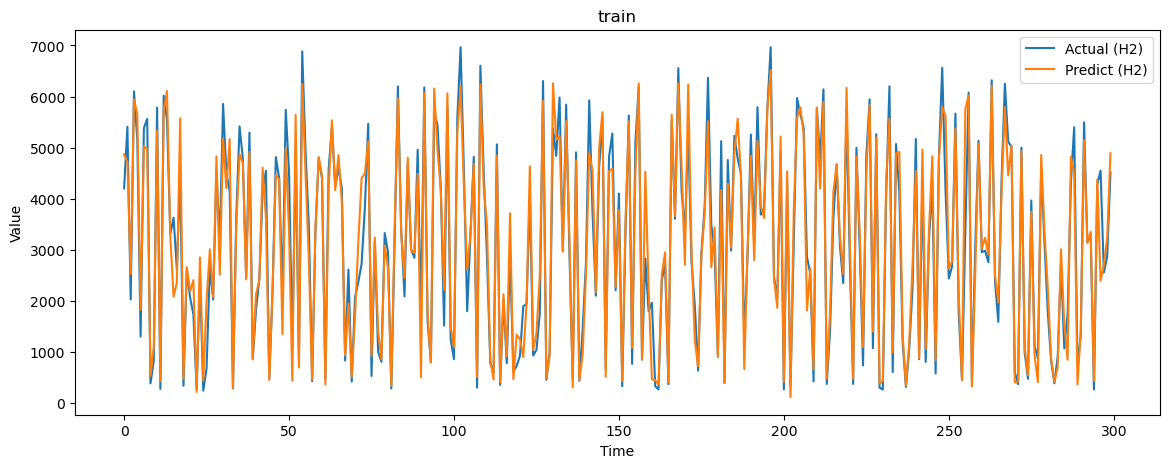

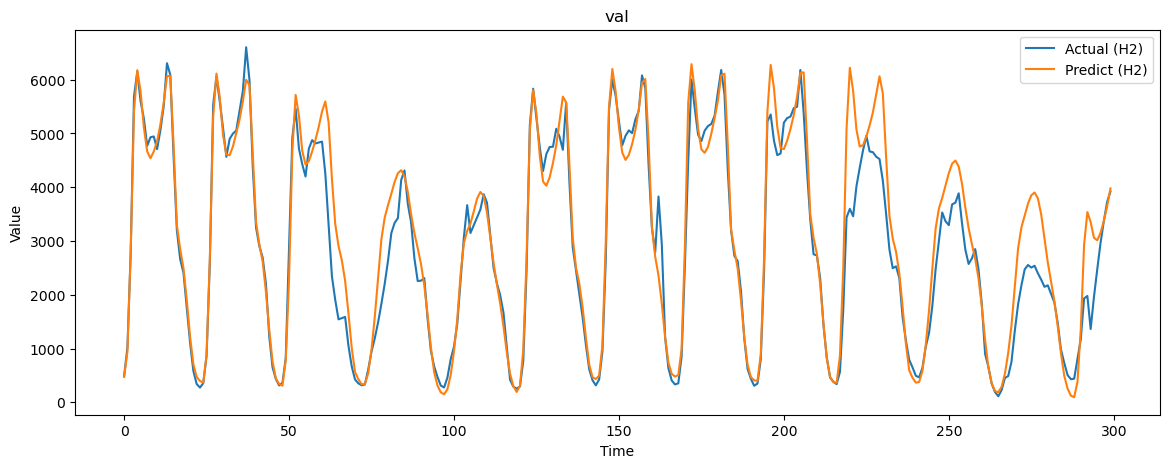

[I 2025-11-30 19:36:45,672] A new study created in memory with name: no-name-0355dbc5-6b94-452c-bd0a-e64d1e863e61
[I 2025-11-30 19:37:19,573] Trial 0 finished with value: 270.69464111328125 and parameters: {'hidden_size': 147, 'lr': 0.001997719605413664, 'batch_size': 64}. Best is trial 0 with value: 270.69464111328125.
[I 2025-11-30 19:38:05,912] Trial 1 finished with value: 289.55462646484375 and parameters: {'hidden_size': 151, 'lr': 0.0015706874574672623, 'batch_size': 32}. Best is trial 0 with value: 270.69464111328125.
[I 2025-11-30 19:38:35,626] Trial 2 finished with value: 339.37347412109375 and parameters: {'hidden_size': 122, 'lr': 0.0001111742225857672, 'batch_size': 64}. Best is trial 0 with value: 270.69464111328125.
[I 2025-11-30 19:39:04,719] Trial 3 finished with value: 277.5224609375 and parameters: {'hidden_size': 44, 'lr': 0.004495586655554282, 'batch_size': 32}. Best is trial 0 with value: 270.69464111328125.
[I 2025-11-30 19:39:38,889] Trial 4 finished with value: 

Best trial hyperparams:
{'hidden_size': 181, 'lr': 0.002586241449321756, 'batch_size': 64}
Best MAE: 263.1955261230469
Epoch 1/6 train_loss=0.013324 val_loss=0.005667
Epoch 2/6 train_loss=0.005863 val_loss=0.003819
Epoch 3/6 train_loss=0.005346 val_loss=0.003823
Epoch 4/6 train_loss=0.004838 val_loss=0.003548
Epoch 5/6 train_loss=0.004706 val_loss=0.003491
Epoch 6/6 train_loss=0.004385 val_loss=0.003076

Test Metrics with best params:
{'MAE': 270.24273681640625, 'RMSE': np.float64(426.5808833035067), 'NSE': np.float32(0.95379186), 'R2': 0.9537917971611023}


In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])

    # DataLoaders 
    train_loader_opt = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader_opt   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Model 
    model = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=CFG.horizon).to(CFG.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")

    EPOCHS_OPT = 6
    for ep in range(EPOCHS_OPT):
        model.train()
        for xb, yb in train_loader_opt:
            xb, yb = xb.to(CFG.device), yb.to(CFG.device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # Validation 
        model.eval()
        Ys, Ps = [], []
        with torch.no_grad():
            for xb, yb in val_loader_opt:
                xb = xb.to(CFG.device)
                pred = model(xb)
                Ys.append(yb.cpu().numpy())
                Ps.append(pred.cpu().numpy())

        Y_val = np.vstack(Ys)
        P_val = np.vstack(Ps)

        # Inverse scaling
        Y_val_inv = scaler_y.inverse_transform(Y_val)
        P_val_inv = scaler_y.inverse_transform(P_val)

        val_mae = mean_absolute_error(Y_val_inv, P_val_inv)

        trial.report(val_mae, ep)

        if val_mae < best_val_loss:
            best_val_loss = val_mae

        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) 

print("Best trial hyperparams:")
print(study.best_trial.params)
print("Best MAE:", study.best_trial.value)

In [ ]:
best_params = study.best_trial.params
hidden_size = best_params["hidden_size"]
lr          = best_params["lr"]
batch_size  = best_params["batch_size"]

train_loader_best = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_best   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader_best  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Model final
model_best = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=CFG.horizon)
model_best = train_loop(model_best, train_loader_best, val_loader_best, epochs=CFG.epochs, lr=lr)

# Evaluate Test
metrics_test, Y_test_inv, P_test_inv = evaluate_model(model_best, test_loader_best, scaler_y)
print("\nTest Metrics with best params:")
print(metrics_test)